### [POC 1] NGLY1 deficiency KG extraction

This simple analysis demonstrates generic relation and entity extraction via language models from a short (~3.5k chars, ~800 tokens), dense description of the pathophysiology underlying NGLY1 deficiency.  Outline:

1. Use an LLM to extract a semi-structured graph of concepts related to NGLY1 deficiency
2. Identify those most relevant for drug development
3. Use an LLM to generate a structured graph representation (node-link JSON)
4. Analyze results

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import logging
import pandas as pd
import networkx as nx
from ngly1_gpt import utils, llm
logging.basicConfig(level=logging.INFO, stream=sys.stdout)
pd.set_option('display.max_colwidth', None)

#### Input

This is an opportune passage from [Prospective Phenotyping of NGLY1-CDDG, the First Congenital Disorder of Deglycosylation](https://pubmed.ncbi.nlm.nih.gov/27388694) (2020 - PMC7477955) that captures many characteristics of `NGLY deficiency` well:

In [137]:
disease = utils.NGLY1_DEFICIENCY
text = """
Hypotheses Generated for Pathophysiology of Clinical Findings

Our detailed assessment of the phenotypic features has also led to several hypotheses regarding underlying pathophysiology. The strong correlation between brain atrophy on MRI and functional assessments suggests that loss of neurons contributes to the functional impairment. The atrophy also correlated with CSF metabolites (BH4, 5-HIAA, HVA), which are known to be lower when there is damage to neurotransmitter producing neurons. This suggests that these biochemical abnormalities may be secondary to brain atrophy.

Results from MRS showed that as functional impairment worsened and age increased, NAA decreased, while choline, myo-inositol and creatine increased. Additionally, creatine and myoinositol were inversely correlated, and NAA directly correlated, with neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, and neopterin, Supplementary Figure S3). NAA may be found exclusively in neurons and declines as neurons become unhealthy or die. Elevations in choline could be consistent with a relative abundance of glial cells secondary to neuronal loss. Myo-inositol is a glia-specific marker that is elevated by gliosis or inflammation; in our cohort we do not have any evidence of inflammation. Creatine levels are relatively higher in glial cells compared to neurons. Taken together, the MRS findings suggest that there is a relative abundance of glial cells compared to neurons in the brain of NGLY1-CDDG individuals, possibly due to loss of neurons, and that the degree of this imbalance contributes significantly to the severity of the phenotype.

The impaired sweat response, largely affecting distal responses, is consistent with a small fiber neuropathy rather than a central etiology or generalized cholinergic dysfunction. Albumin CSF/serum quotient, or QAlb, is a marker of blood-CSF barrier dysfunction, and its value is inversely correlated to the CSF turnover rate. There was no significant change in the QAlb ratio (data not shown), arguing against increased turnover as a possible etiology. Regardless of the mechanism, we propose that decreased CSF protein and albumin concentrations represent a novel diagnostic marker for this disorder.

Individuals with NGLY1-CDDG and those with N-linked glycosylation disorders share the phenotypic features of low cholesterol, hepatopathy, peripheral neuropathy, retinal and optic nerve abnormalities, seizures, developmental delay with socialization as a relative strength, and delayed bone age. NGLY1-CDDG also overlaps with O-linked glycosylation disorders with respect to hypolacrima. There may be a pathogenic relationship; N-glycanase 1 catalyzes the cleavage of the amide bond between the proximal N-acetylglucosamine residue of glycans and the asparagine residue of the protein, so NGLY1-CDDG could impair glycan recycling and lead to hypoglycosylation. Indeed, the individuals with NGLY1-CDDG exhibited subtle abnormalities in transferrin and ApoC-III glycosylation.

Another hypothesis for the etiology of the NGLY1-CDDG phenotype is based on the fact that misfolded glycoproteins are processed through the endoplasmic reticulum associated degradation pathway (ERAD) and then retrotranslocated into the cytoplasm. There, N-glycanase is the first step in further degradation of these molecules, making ERAD dysfunction a possible pathophysiologic contributor especially given evidence of ER-stress in mouse embryonic fibroblasts. However, preliminary experiments found no impairment or enhancement of standard ERAD marker expression under normal conditions in NGLY1-CDDG patient fibroblasts (H.H. Freeze, personal communication, April 2016).
"""
print(text)


Hypotheses Generated for Pathophysiology of Clinical Findings

Our detailed assessment of the phenotypic features has also led to several hypotheses regarding underlying pathophysiology. The strong correlation between brain atrophy on MRI and functional assessments suggests that loss of neurons contributes to the functional impairment. The atrophy also correlated with CSF metabolites (BH4, 5-HIAA, HVA), which are known to be lower when there is damage to neurotransmitter producing neurons. This suggests that these biochemical abnormalities may be secondary to brain atrophy.

Results from MRS showed that as functional impairment worsened and age increased, NAA decreased, while choline, myo-inositol and creatine increased. Additionally, creatine and myoinositol were inversely correlated, and NAA directly correlated, with neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, and neopterin, Supplementary Figure S3). NAA may be found exclusively in neurons and declines as neurons become unhealthy

#### Extraction

First prompt to generate a semi-structured, natural language representation of the concepts, entities and relationships in the text.  In my experience, chain-of-thought prompting is at least as effective when doing this prior to prompting for a structured format in a final result, and it makes the final result more interpretable.  

You can see below that the model is prompted to identify biomedical concepts/relations **and** to classify those that comprise any sort of potential therapeutic opportunity:

In [3]:
graph_description = llm.extract_graph_description(text, disease=disease)
print(graph_description)

INFO:ngly1_gpt.llm:Prompt:
Text will be provided that contains information from a published, biomedical research article about NGLY1 deficiency. 

Extract all biological entities and processes that are hypothesized in this text as directly involved in the etiology of NGLY1 deficiency.  The intent of this extraction will ultimately be to create a graph (aka network) of these entities and processes as nodes with edges describing relations between them.  The focus will be on any proteins, genes, metabolites, pathways or other biological functions that are most likely to provide a means for chemical or physical intervention that may alter the course of the disease. 

Let's think step by step.  List the nodes first, and then the types of edges/relations, and then which of these constitute opportunities for intervention.

--- BEGIN TEXT ---

Hypotheses Generated for Pathophysiology of Clinical Findings
Our detailed assessment of the phenotypic features has also led to several hypotheses rega

INFO:ngly1_gpt.llm:Response:
Nodes (Biological Entities):
1. Neurons
2. Brain atrophy
3. CSF metabolites (BH4, 5-HIAA, HVA)
4. Neurotransmitter producing neurons
5. Brain
6. MRS
7. Functional impairment
8. Age
9. NAA
10. Choline
11. Myo-inositol
12. Creatine
13. Neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, neopterin)
14. Glial cells
15. NGLY1-CDDG (NGLY1-Congenital Disorder of Glycosylation)
16. Sweat response
17. Distal responses
18. Small fiber neuropathy
19. Central etiology
20. Generalized cholinergic dysfunction
21. Albumin CSF/serum quotient (QAlb)
22. Blood-CSF barrier dysfunction
23. CSF turnover rate
24. CSF protein and albumin concentrations
25. Cholesterol levels
26. Hepatopathy
27. Peripheral neuropathy
28. Retinal and optic nerve abnormalities
29. Seizures
30. Developmental delay
31. Socialization 
32. Delayed bone age
33. Hypolacrima
34. N-linked glycosylation disorders
35. O-linked glycosylation disorders
36. N-glycanase 1
37. N-acetylglucosamine residue of glycans
38.

Convert the above to JSON:

In [13]:
graph_json = llm.extract_graph_json(text, description=graph_description, disease=disease)
print(graph_json)

INFO:ngly1_gpt.llm:Prompt:
The following text contains information from a published, biomedical research article about NGLY1 deficiency:

--- BEGIN TEXT ---

Hypotheses Generated for Pathophysiology of Clinical Findings
Our detailed assessment of the phenotypic features has also led to several hypotheses regarding underlying pathophysiology. The strong correlation between brain atrophy on MRI and functional assessments suggests that loss of neurons contributes to the functional impairment. The atrophy also correlated with CSF metabolites (BH4, 5-HIAA, HVA), which are known to be lower when there is damage to neurotransmitter producing neurons. This suggests that these biochemical abnormalities may be secondary to brain atrophy.

Results from MRS showed that as functional impairment worsened and age increased, NAA decreased, while choline, myo-inositol and creatine increased. Additionally, creatine and myoinositol were inversely correlated, and NAA directly correlated, with neurotransmi

Load as networkx:

In [119]:
graph = llm.convert_graph_json(graph_json, disease=disease)
graph.number_of_nodes(), graph.number_of_edges()

(47, 46)

Show some info about the nodes in the graph:

In [125]:
node_info = pd.DataFrame([
    {**dict(id=id), **data} 
    for id, data in graph.nodes(data=True)
]).set_index('id', drop=False)
node_info

,id,label,type,therapeutic
id,,,,
1,1,Neurons,cell type,Management
2,2,Brain atrophy,pathological process,Management
3,3,"CSF metabolites (BH4, 5-HIAA, HVA)",biological marker,Unknown
4,4,Neurotransmitter producing neurons,cell type,Unknown
5,5,Brain,organ,Unknown
6,6,MRS,biological marker,Unknown
7,7,Functional impairment,symptom,Management
8,8,Age,chronological measurement,Unknown
9,9,NAA,biological marker,Unknown


#### Analysis

Show nodes by therapeutic opportunity category where `Interventional` is the most actionable and `Management` implies symptoms or complications of the disease that could also be treated:

In [134]:
(
    node_info
    .pipe(lambda df: pd.concat([
        g['label'].rename(k)
        .pipe(lambda s: s.loc[s.str.len().sort_values(ascending=False).index])
        .to_frame().reset_index(drop=True)
        for k, g in df.groupby('therapeutic')
    ], axis=1))
    .fillna('')
)

,Interventional,Management,Unknown
0,Endoplasmic reticulum associated degradation pathway (ERAD),Retinal and optic nerve abnormalities,"Neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, neopterin)"
1,Hypoglycosylation,Generalized cholinergic dysfunction,ER-stress in mouse embryonic fibroblasts
2,Glycan recycling,Small fiber neuropathy,Transferrin and ApoC-III glycosylation
3,N-glycanase 1,Functional impairment,N-acetylglucosamine residue of glycans
4,,Peripheral neuropathy,CSF protein and albumin concentrations
5,,Developmental delay,"CSF metabolites (BH4, 5-HIAA, HVA)"
6,,Cholesterol levels,Neurotransmitter producing neurons
7,,Delayed bone age,Asparagine residue of the protein
8,,Sweat response,Albumin CSF/serum quotient (QAlb)
9,,Socialization,N-linked glycosylation disorders


Show nodes by type:

In [136]:
(
    node_info
    .pipe(lambda df: pd.concat([
        g['label'].rename(k)
        .pipe(lambda s: s.loc[s.str.len().sort_values(ascending=False).index])
        .to_frame().reset_index(drop=True)
        for k, g in df.groupby('type')
    ], axis=1))
    .pipe(lambda df: df[df.notnull().sum().sort_values().index])
    .fillna('')
)

,biological pathway,chronological measurement,enzyme,etiology,organ,biochemical component,biological function,biological process,cell type,genetic disorder,pathological process,symptom,biological marker
0,Endoplasmic reticulum associated degradation pathway (ERAD),Age,N-glycanase 1,Central etiology,Brain,N-acetylglucosamine residue of glycans,Distal responses,ER-stress in mouse embryonic fibroblasts,Neurotransmitter producing neurons,N-linked glycosylation disorders,Retinal and optic nerve abnormalities,Generalized cholinergic dysfunction,"Neurotransmitter levels (5-HIAA, 5-HVA, 3-OMD, neopterin)"
1,,,,,,Asparagine residue of the protein,Sweat response,Transferrin and ApoC-III glycosylation,NGLY1-CDDG patient fibroblasts,O-linked glycosylation disorders,Blood-CSF barrier dysfunction,Functional impairment,CSF protein and albumin concentrations
2,,,,,,Misfolded glycoproteins,Socialization,Glycan recycling,Glial cells,NGLY1 deficiency,Small fiber neuropathy,Peripheral neuropathy,"CSF metabolites (BH4, 5-HIAA, HVA)"
3,,,,,,,,,Neurons,NGLY1-CDDG,Hypoglycosylation,Developmental delay,Albumin CSF/serum quotient (QAlb)
4,,,,,,,,,,,Brain atrophy,Delayed bone age,ERAD marker expression
5,,,,,,,,,,,Hepatopathy,Hypolacrima,Cholesterol levels
6,,,,,,,,,,,,Seizures,CSF turnover rate
7,,,,,,,,,,,,,Myo-inositol
8,,,,,,,,,,,,,Creatine
9,,,,,,,,,,,,,Choline


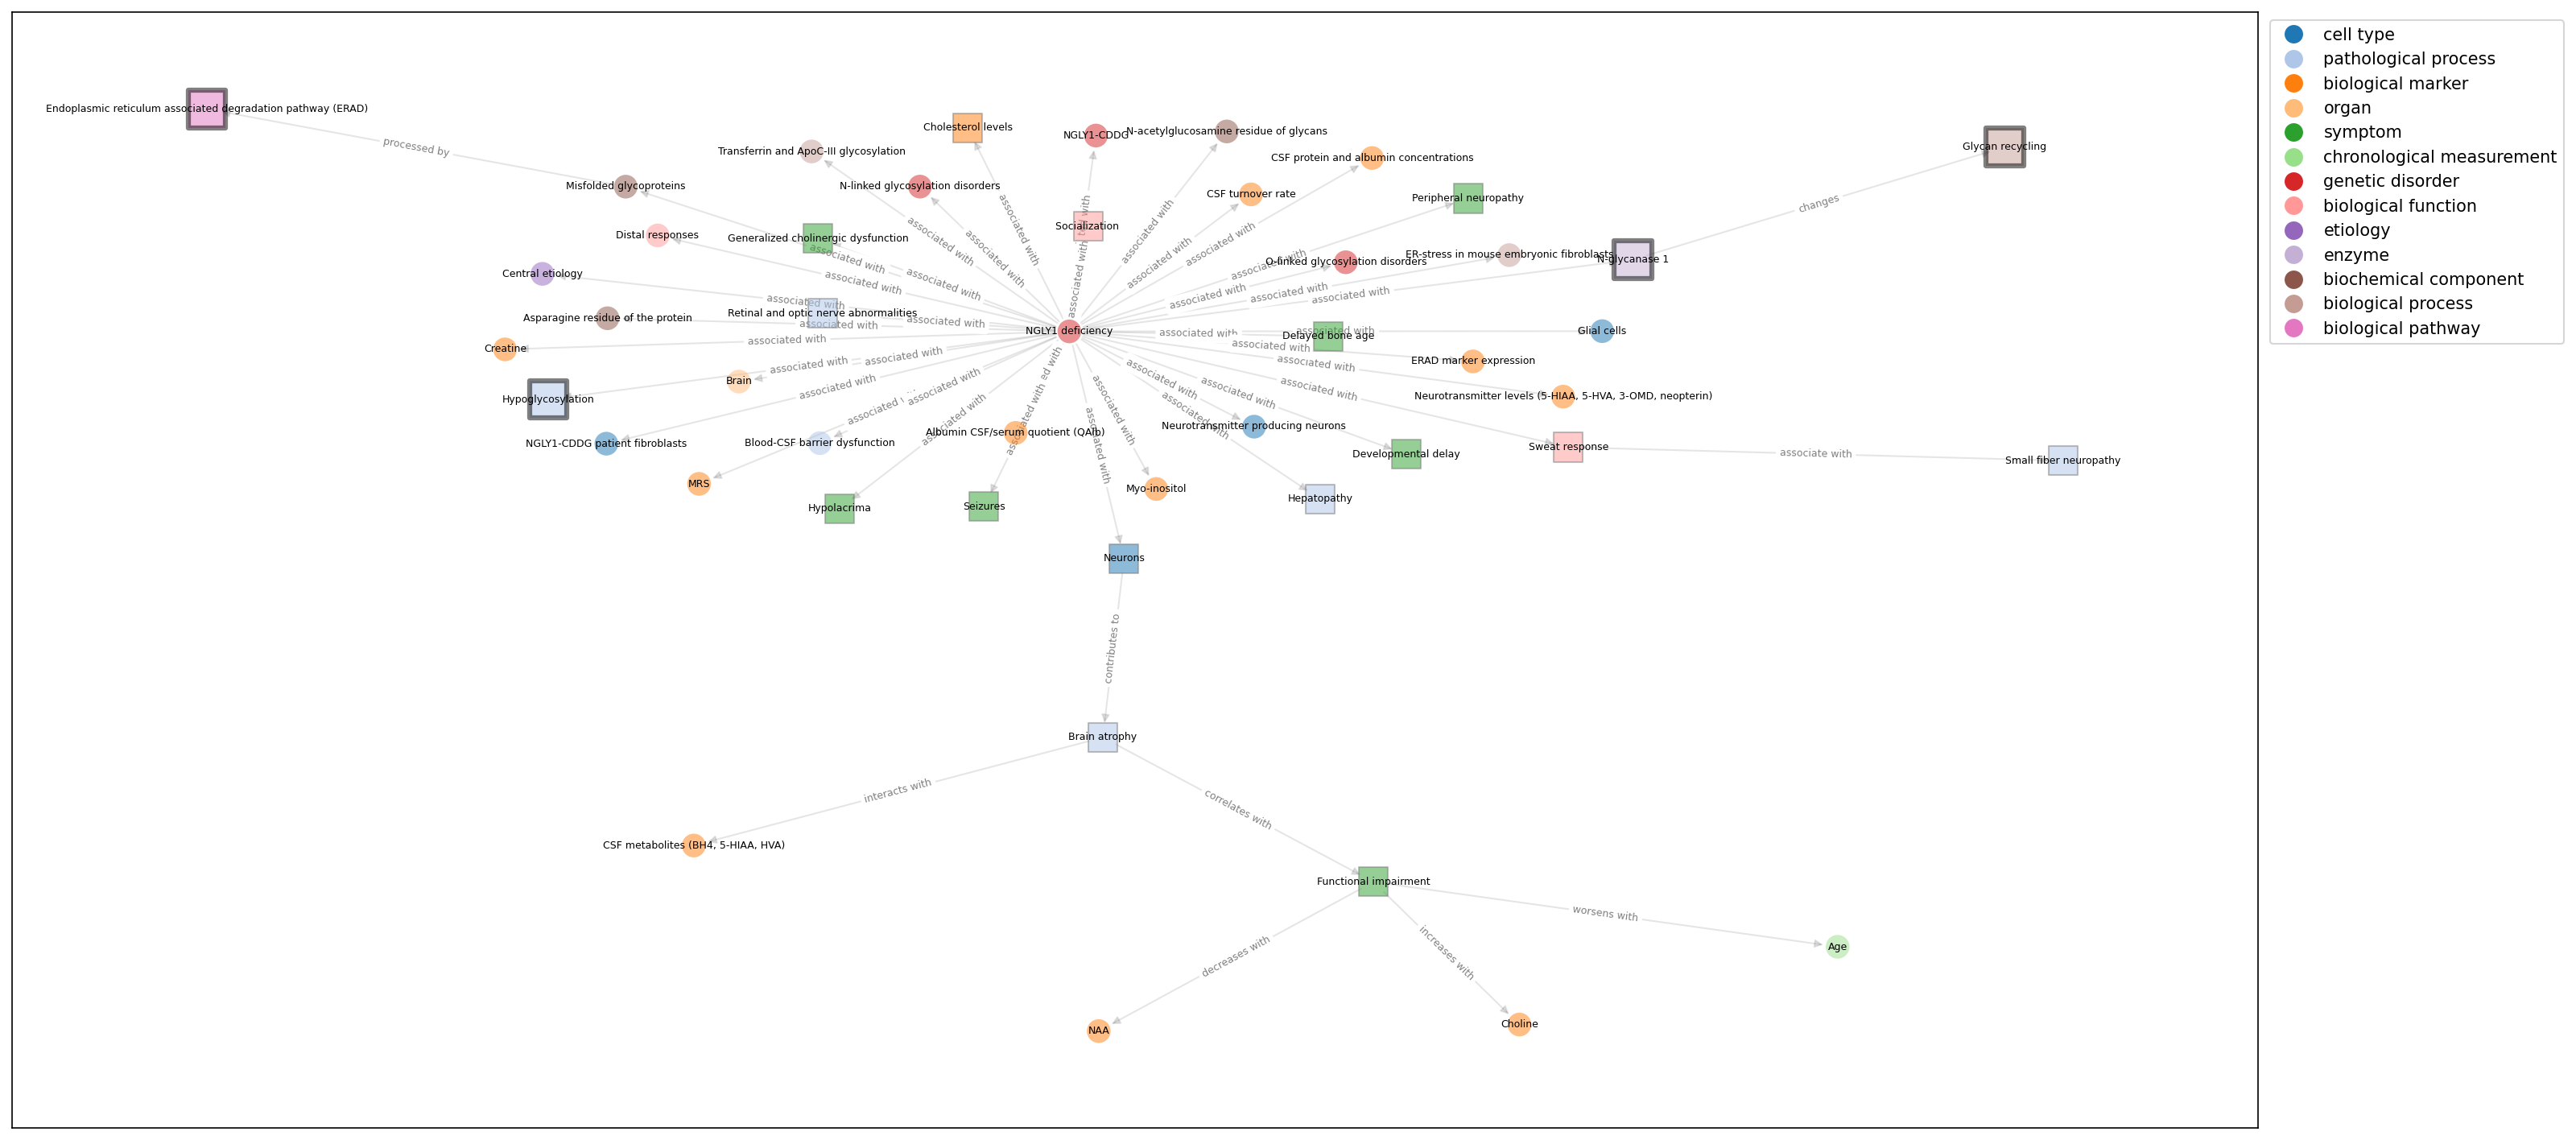

In [154]:
def plot_graph(graph, node_info):
    import matplotlib.pyplot as plt
    from networkx.drawing.nx_agraph import graphviz_layout
    from matplotlib.lines import Line2D
    plt.figure(figsize=(24, 12), dpi=150)
    pos = graphviz_layout(graph, prog="neato")
    cmap = utils.get_colormap(node_info["type"].unique(), cmap="tab20")
    node_color=node_info["type"].map(cmap).fillna('grey')
    node_config = {"Interventional": (3, "black", "s", 500), "Management": (1, "grey", "s", 300)}
    for k, g in node_info.groupby("therapeutic"):
        nodelist = g["id"].tolist()
        linewidths, edgecolors, node_shape, node_size = node_config.get(k, (0, "black", "o", 200))
        nx.draw_networkx_nodes(
            graph, pos, nodelist=nodelist, alpha=.5,
            linewidths=linewidths, edgecolors=edgecolors, node_shape=node_shape,
            node_size=node_size, node_color=node_color.loc[nodelist]
        )
    nx.draw_networkx_edges(graph, pos, alpha=.1)
    nx.draw_networkx_labels(graph, pos, labels={n: graph.nodes[n]["label"] for n in graph.nodes()}, font_size=6)
    nx.draw_networkx_edge_labels(graph, pos, alpha=.5, edge_labels={(e[0], e[1]): graph.edges[e].get("type", "None") for e in graph.edges}, font_size=6)

    plt.legend(handles=[
        Line2D([0], [0], marker='o', color=v, label=k, markerfacecolor=v, markersize=10, linewidth=0)
        for k, v in cmap.items()
    ], loc='upper right', bbox_to_anchor=(1.14, 1))
    plt.show()

from IPython.display import HTML
display(HTML(f"<h2>Pathophysiology decomposition ({disease})</h2>"))
plot_graph(graph, node_info)
display(HTML(
    "<strong>Note</strong>: Larger squares with darker borders represent "
    "terms classified by the LLM as most likely to be applicable for therapeutic intervention.  Smaller squares with "
    "lighter borders on the other hand represent symptoms/conditions that might also be managed by drugs.  Circles represent everything else."
))
